In [ ]:
 # This is the same code from the previous section, nothing new here.
try:
  # We must install required packages if we are in Google Colab
  import google.colab
  %pip install roboticstoolbox-python>=1.0.2
except:
  # We are not in Google Colab
  # Apply custon style to notebook
  from IPython.core.display import HTML
  import pathlib
  styles_path = pathlib.Path(pathlib.Path().absolute(), "style", "style.css")
  styles = open(styles_path, "r").read()
  HTML(f"<style>{styles}</style>")

# 5.0 Trust-Region Constraint Method


## Table of Contents

> #### 5.1 Introduction
> #### 5.2 Trust Constraint Method
> #### 5.3 Definitions
> #### 5.4 Limitations and Testing

# **Trust Region Constrained Optimization Method**

---
# 5.1 Introduction
 Numerical Inverse Kinematics allowed us to obtain the sets of joint angles necessary to acheive a specific pose. However, some of these solutions obtained may not be physically feasible in our work space. For example, if we feed an incorrect set of joint angles into our forward kinematics function, the arm may collide with ground/table or even collide with itself in an attempt to achieve the desired pose. To avoid this issue we use an optimization technique known as Trust Constraint method.
# 5.2 Trust- Region Constrained Method
The Trust Region Constraint method, also known as the Trust Constraint method, is a powerful optimization technique used to minimize a scalar function subject to constraints. In this context, "trust" represents our confidence in the accuracy of the inverse kinematics solution, while "constraint" refers to any additional conditions or limitations we need to account for during the motion planning process. The "trust constraint optimization" technique involves incorporating these constraints into the optimization process to find a solution that not only achieves the desired task but also adheres to the specified constraints.<br>


# 5.3 Definitions
To further understand the trust constraint method in detail, let us first define a few parameters:
* **Total_error**: Calculated as the sum of the pose error and the z error. This is the function that we are trying to minimise using trust region constrained optimisation.  
* **gtol**:A parameter used to determine the convergence criterion based on the gradient of the objective function.It specifies the tolerance level for the norm of the gradient. If the norm of the gradient falls below this threshold, the optimization process is considered to have converged.<br>
*   **xtol**: A parameter used to determine the convergence criterion based on the step size taken by the optimizer.It specifies the tolerance level for the difference between consecutive iterations' solution vectors.<br>
*   **barrier_tol**: A parameter used specifically in barrier methods, which are a type of optimization technique used for constrained optimization problems.In barrier methods, inequality constraints are transformed into a series of barrier functions, which are used to penalize solutions that violate the constraints.This parameter specifies the tolerance level for how close the solution should be to the feasible region defined by the constraints.<br>






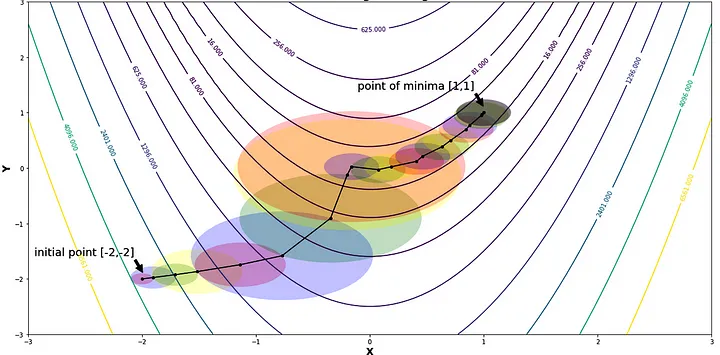

**Figure: Visualisation of Trust Constrained Method**<br>
Source: https://medium.com/trust-region-methods/temp-blog-1b51189594a

In our code, the comprehensive error function incorporates various factors, including a z-error component to prevent any of our robot's joints from colliding with the table. To elucidate further, let's consider a scenario where our target solution is [1,1], and we begin with an initial estimation (e.g., -2,-2). Our objective is to locate the minimum within a search region characterized by a radius, denoted as 'x'. The size of this radius dynamically adjusts based on our proximity to the desired solution: it expands or contracts depending on whether we're moving closer to or further away from the target.

Should the 'x' value diminish below a specified tolerance of x_tol = 0.02  (default value of 10^-7), the algorithm halts. Notably, it's important to recognize that the Lagrangian gradient reaches its minimum precisely at the sought-after minima. With this understanding, we can gauge our local minimum against the global solution. Analogous to the search radius, if the disparity between the local and global minima falls below a predefined threshold ('gtol', typically 10^-7), the algorithm terminates.

Additionally, we employ 'barrier_tol' to ensure that the obtained solutions align with the physical constraints imposed by the robot's joint limitations. This parameter serves to guarantee that the solutions obtained are not only mathematically optimal but also viable within the practical constraints of the robotic system.

Our trust contraint method can be seen below with the defined terms implemented:

```
import numpy as np
from scipy.optimize import minimize
from Rx import Rx
from Rz import Rz
from fk import fk
from QuadraticError import QuadraticError
from angle_guess import angle_guess
from T import T
from Err import Err

def trust_constr(initial_guess, Tt):
    # Define the fixed transformation matrices outside the optimization loop
    E1 = T(0, 0, 0.15643)
    E2 = Rx(np.pi)
    ETS1 = np.dot(E1, E2)
    E4 = T(0, 0, -0.12838)
    E5 = T(0, 0.00538, 0)
    E6 = Rx(np.pi/2)
    ETS2 = np.linalg.multi_dot([E4, E5, E6])
    E8 = T(0, 0, -0.00638)
    E9 = T(0, -0.21038, 0)
    E10 = Rx(-np.pi/2)
    ETS3 = np.linalg.multi_dot([E8, E9, E10])
    E12 = T(0, 0, -0.21038)
    E13 = T(0, 0.00638, 0)
    E14 = Rx(np.pi/2)
    ETS4 = np.linalg.multi_dot([E12, E13, E14])
    E16 = T(0, 0, -0.00638)
    E17 = T(0, -0.20843, 0)
    E18 = Rx(-np.pi/2)
    ETS5 = np.linalg.multi_dot([E16, E17, E18])
    E20 = T(0, 0, -0.10593)
    E21 = Rx(np.pi/2)
    ETS6 = np.dot(E20, E21)
    E23 = T(0, -0.10593, 0)
    E24 = Rx(-np.pi/2)
    ETS7 = np.dot(E23, E24)
    E26 = T(0, 0, -0.06153)
    E27 = Rx(np.pi)
    ETS8 = np.dot(E26, E27)


    def objective(x):
        Joint4_Matrix = np.linalg.multi_dot([ETS1, Rz(x[0]), ETS2, Rz(x[1]), ETS3, Rz(x[2]), ETS4, Rz(x[3]), ETS5, Rz(x[4])])
        Joint5_Matrix = np.linalg.multi_dot([ETS1, Rz(x[0]), ETS2, Rz(x[1]), ETS3, Rz(x[2]), ETS4, Rz(x[3]), ETS5, Rz(x[4]), ETS6, Rz(x[5])])
        Joint6_Matrix = np.linalg.multi_dot([ETS1, Rz(x[0]), ETS2, Rz(x[1]), ETS3, Rz(x[2]), ETS4, Rz(x[3]), ETS5, Rz(x[4]), ETS6, Rz(x[5]), ETS7, Rz(x[6])])
        EndEffector_Matrix = np.linalg.multi_dot([ETS1, Rz(x[0]), ETS2, Rz(x[1]), ETS3, Rz(x[2]), ETS4, Rz(x[3]), ETS5, Rz(x[4]), ETS6, Rz(x[5]), ETS7, Rz(x[6]), ETS8])

        # a = 1e300

        # z_error = ((a)**(-(Joint3_Matrix[2,3] - 0.04))) + ((a)**(-(Joint4_Matrix[2,3] - 0.04))) + ((a)**(-(Joint5_Matrix[2,3] - 0.04))) + ((a)**(-(Joint6_Matrix[2,3] - 0.04))) + ((a)**(-(EndEffector_Matrix[2,3] - 0.04)))

        a = 1e-100
        jz4 = (1/(np.abs(a)*np.sqrt(np.pi)))*np.exp(-(np.square((Joint4_Matrix[2,3]-0.02)/a)))
        jz5 = (1/(np.abs(a)*np.sqrt(np.pi)))*np.exp(-(np.square((Joint5_Matrix[2,3]-0.02)/a)))
        jz6 = (1/(np.abs(a)*np.sqrt(np.pi)))*np.exp(-(np.square((Joint6_Matrix[2,3]-0.02)/a)))
        jz7 = (1/(np.abs(a)*np.sqrt(np.pi)))*np.exp(-(np.square((EndEffector_Matrix[2,3]-0.04)/a)))
        z_error = jz4 + jz5 + jz6 + jz7
        # pose_error = np.linalg.norm(Err(Tt, fk(x)))
        pose_error = np.linalg.norm(Err(Tt, fk(x)))


        # Combine both errors with a weighted sum
        total_error = pose_error + z_error

        return total_error

    # Define constraints
    lb = np.deg2rad([-360, -128.9, -360, -147.8, -360, -120.3, -360])
    ub = np.deg2rad([360, 128.9, 360, 147.8, 360, 120.3, 360])

    # Initializations
    d = np.empty(7)

    # Perform optimization
    result = minimize(
        objective, initial_guess,
        bounds=list(zip(lb, ub)),
        method='trust-constr',
        jac='2-point',  # You can experiment with '2-point' or '3-point' finite differences
        hessp=None,  # Set to None for now, you can experiment with other options
        options={'maxiter': 200, 'xtol': 0.02},
    )

    # Display results
    if result.success:
        print("Optimization successful.")
        print("Number of iterations:", result.nit)
        print("Optimal Joint Angles:", np.rad2deg(result.x))
        print("Optimal Desired Matrix:")
        print(fk(result.x))
    else:
        print("Optimization did not converge.")

    return np.rad2deg(result.x)

T1 = np.array([[0, 1, 0,  0.1],
                   [1, 0, 0,  0.35],
                   [0, 0, -1,  0.4],
                   [0,  0,  0,  1]])
q1 = angle_guess()
angles2 = trust_constr(q1,T1)
```



# 5.4 Limitations and Testing

Despite their effectiveness in optimizing certain aspects of robotic systems, trust region constrained optimization methods are not without their limitations, which can hinder their applicability and performance in practical robotics scenarios.

1. Computational Complexity: Trust region methods often involve iterative procedures that require evaluating the objective function and its derivatives multiple times. In robotic applications, where real-time performance is critical, this computational overhead can be prohibitive, particularly for complex robotic systems with high-dimensional state spaces or intricate dynamics.

2. Sensitivity to Initial Guesses and Parameters: The performance of trust region methods can be highly sensitive to the choice of initial guesses and tuning parameters, such as the size of the trust region. In robotics, where the optimization may be subject to noise, uncertainty, or varying environmental conditions, finding suitable initial guesses and parameter values that ensure convergence can be challenging and may require extensive tuning.

During our tests with the Kinova arm, we compared various inverse kinematics methods to choose an appropriate method for our pick and place controller. The results can be seen in the table below.



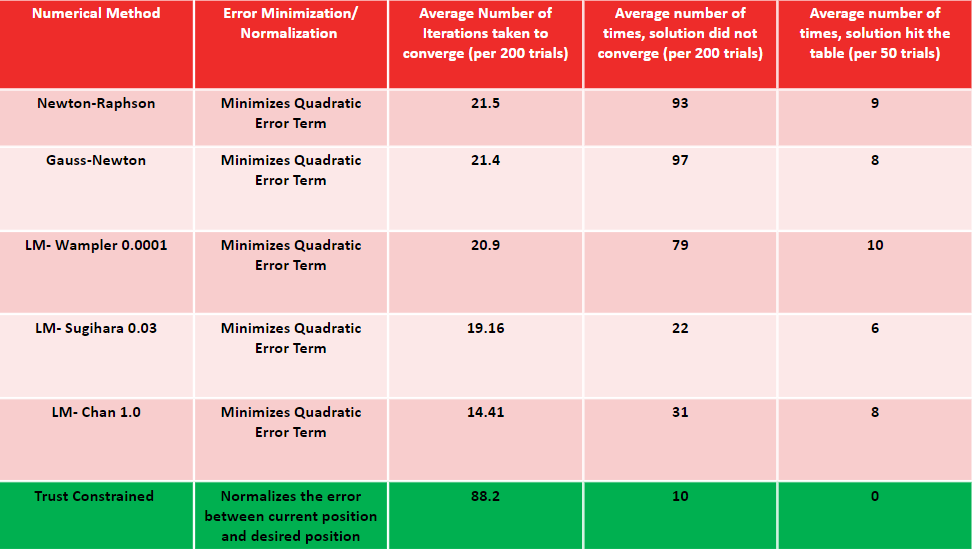

**Figure: Comparison of Trust Constrained Method with other IK Methods**<br>

It can be inferred that despite the Trust Constrained Method exhibiting a slower convergence rate, it notably ensured the avoidance of collisions with the table throughout its operation. This  safety feature was the primary driver behind our decision to opt for this method, ensuring its reliability, integrity and safety of the robotic system during operation.

Upon conducting additional tests on this optimization technique, it became evident that it incurred a failure rate of 30%. We established that any deviation preventing the successful placement of the cube at the designated location constitutes a failure. Such failures encompass instances where the robot obstructs its own movement, fails to converge to a solution, improperly grasps the block, or misplaces it. These setbacks underscore the inherent limitations of the trust constrained method. In subsequent iterations, we aim to enhance the success rate by addressing these challenges and refining the methodology accordingly.






